# Loss Function Effect on Different Distributions

For this exercise we are going to simulate different time series using the sinusoidal form for the deterministic term and using a different distributions in which the average and the median are very different for the noise term. Then, we fit a simple dense neural network with different loss functions in order to fit the model to the data and then recover the error distribution and analyze the mean and the median.

Before proceeding, we import the necessary modules and packages:

In [1]:
# Own Modules

from TimeSeries.classes import *
from TimeSeries.utils import *
from NeuralNetworks.classes import *
from ErrorModelling.classes import *
from ErrorModelling.utils import *

# Other modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras

**Cauchy Stochastic Process**

We simulate the time series with a Cauchy-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\sin(0.25t+1)+\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{Cauchy}(0,1)$$

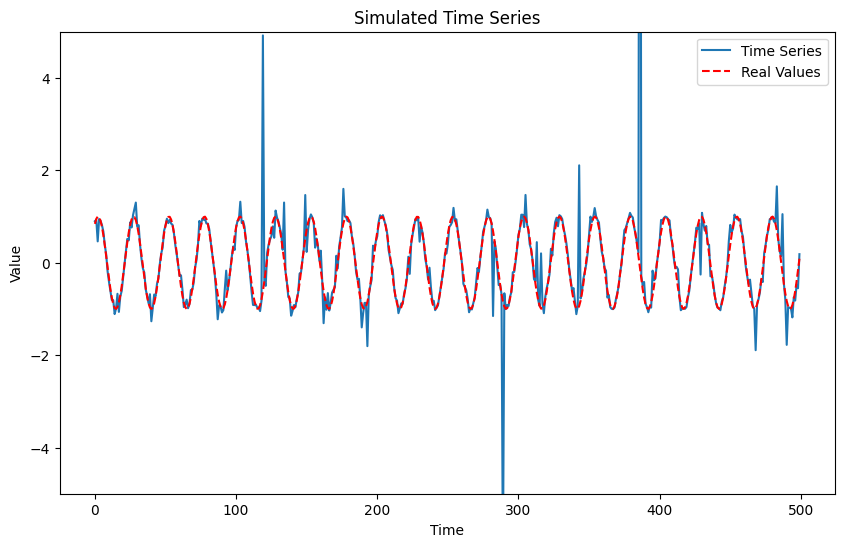

Theoretical Mean: None
Theoretical Std. Dev.: None
Theoretical Median: None



In [10]:
n = 500
loc = 0
scale = 0.1
params = {"A": 1, "B":0.25, "C":1}
normal = CauchyDist({"loc": 0, "scale":0.05})

simul = TimeSeriesSimulator(determ=sinForm,noise=normal)
series = simul.simulate(det_params=params,n=500)
simul.plot_sim(scatter_plot=False)

theory = normal.theory()

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")


Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.

In [11]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])
seq_length = 10
data = series["Value"].values
series["Determ"] = series["Determ"].iloc[seq_length:].reset_index(drop=True)
x, y = create_sequences_from_ts(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "Huber": keras.losses.Huber(delta=0.5)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse","mape"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")


Training with L1 loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3427 - mae: 0.3427 - mape: 129.5284 - mse: 0.8027
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2888 - mae: 0.2888 - mape: 110.0734 - mse: 0.5258
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2506 - mae: 0.2506 - mape: 185.1554 - mse: 1.1792
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2655 - mae: 0.2655 - mape: 91.3368 - mse: 1.7407
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2551 - mae: 0.2551 - mape: 393.5116 - mse: 0.5465
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2094 - mae: 0.2094 - mape: 165.7021 - mse: 0.5847
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2025 - mae: 0.2025 - mape: 164.9041 - mse: 0.3082
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1749 - mae: 0.1749 - mape: 149.4556 - mse: 0.1795
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1705 - mae: 0.1705 - mape: 115.0443 - mse: 0.2582
Epoch 10/50
31/31 ━━━━

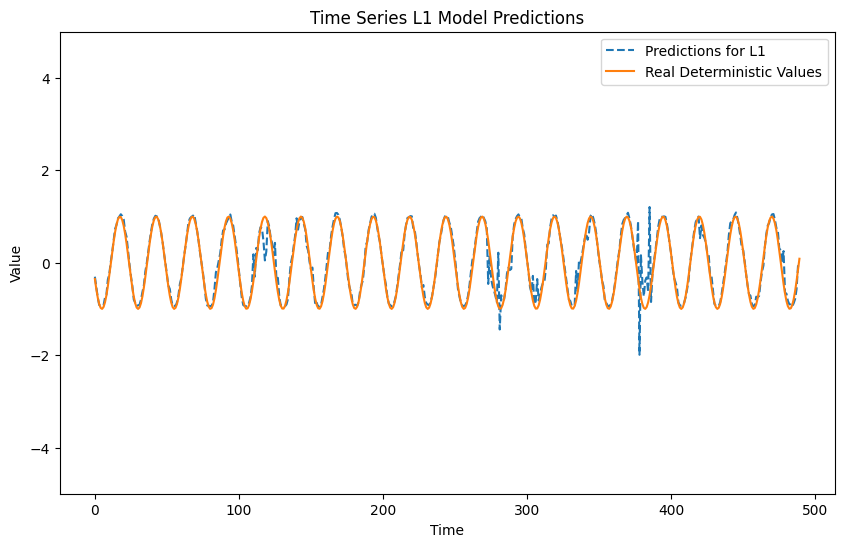

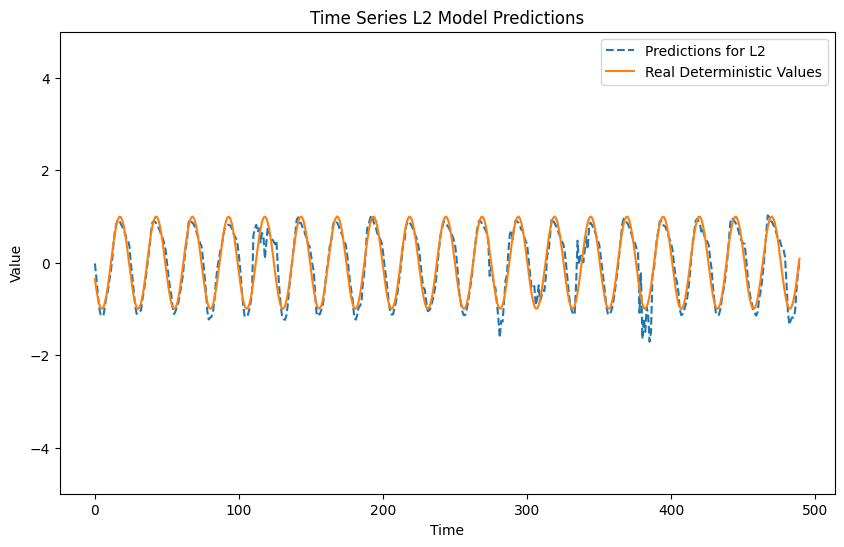

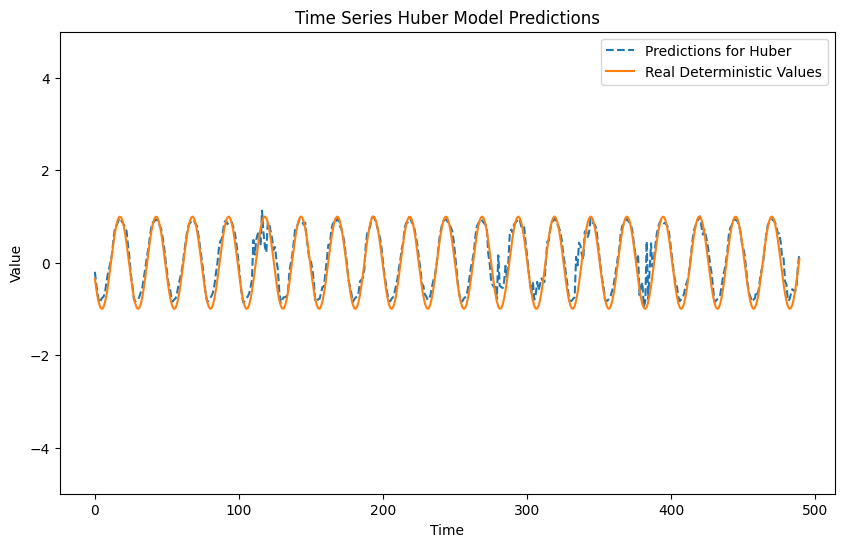

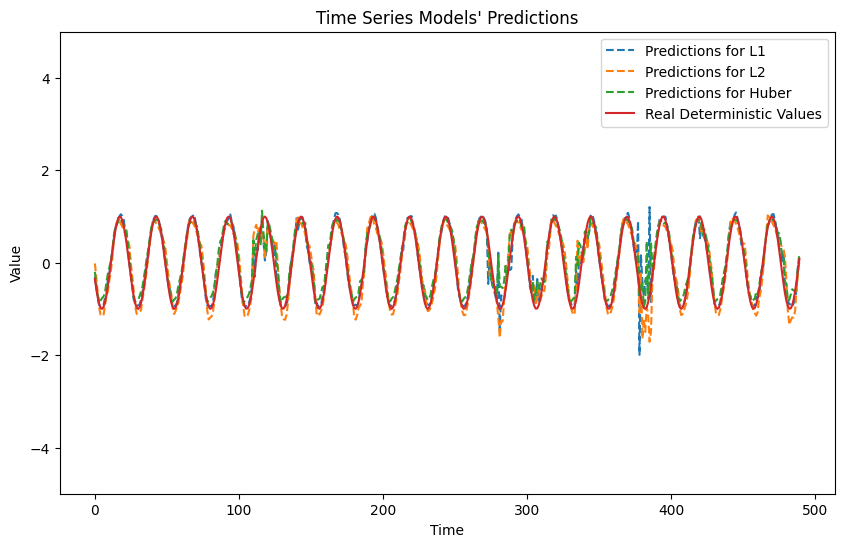

In [12]:
for k in predictions_dict.keys():

    plot_estimations(predictions=predictions_dict[k],series=series,model_name=k,use_total_series=False)

plot_multiple_estimations(pred_dict=predictions_dict,series=series,use_total_series=False)

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for L1 loss...

Mean: 0.021769189138752858 vs. Theoretical Mean: None
Median: -0.03346604436311468 vs. Theoretical Median: None
Standard Dev.: 1.1818976288885152 vs. Theoretical Std. Dev.: None
Skew: 16.95790493050244
Kurtosis: 342.9777143559085
Max: 23.967027117207703
Min: -5.686344087647518




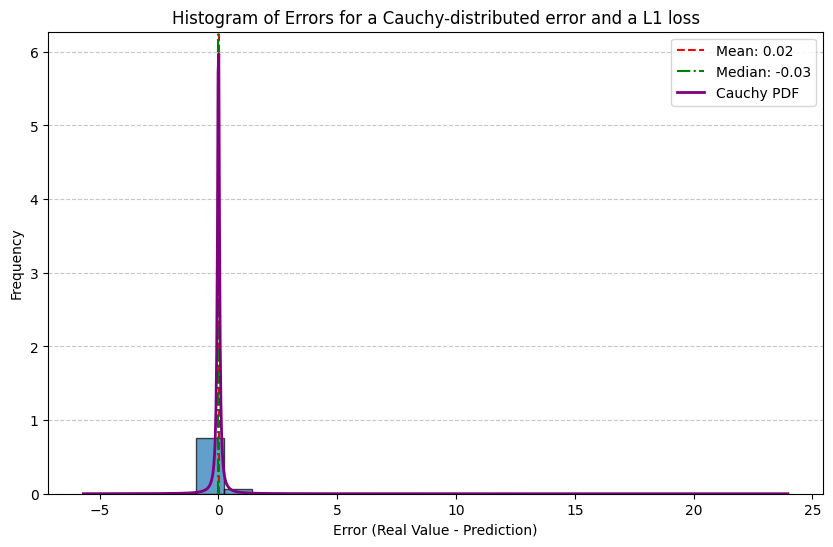

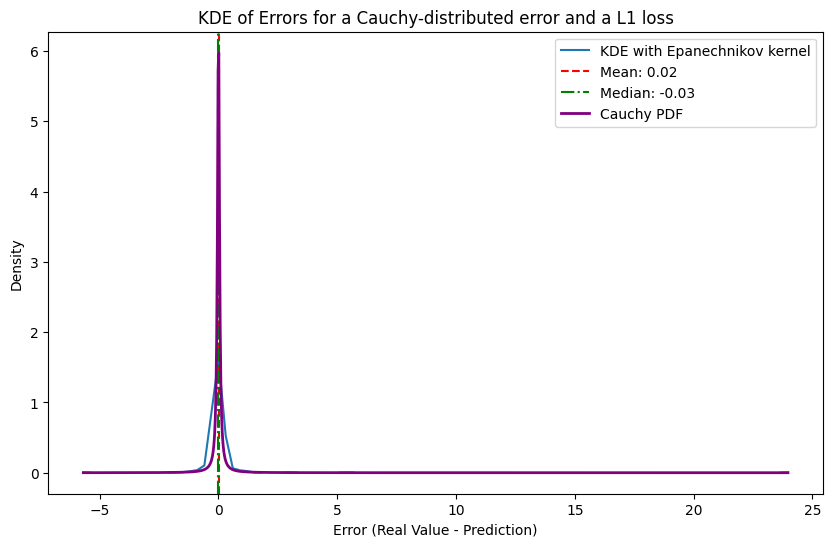

Analyzing errors for L2 loss...

Mean: 0.06418058699908132 vs. Theoretical Mean: None
Median: 0.05537998610324918 vs. Theoretical Median: None
Standard Dev.: 1.1803320948595042 vs. Theoretical Std. Dev.: None
Skew: 16.227727654126273
Kurtosis: 323.30856984419563
Max: 23.625376765325722
Min: -5.670186698960384




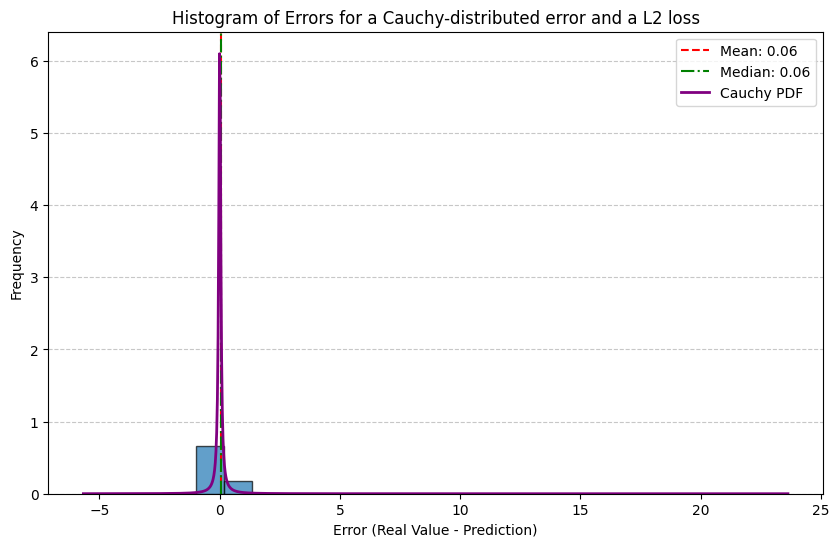

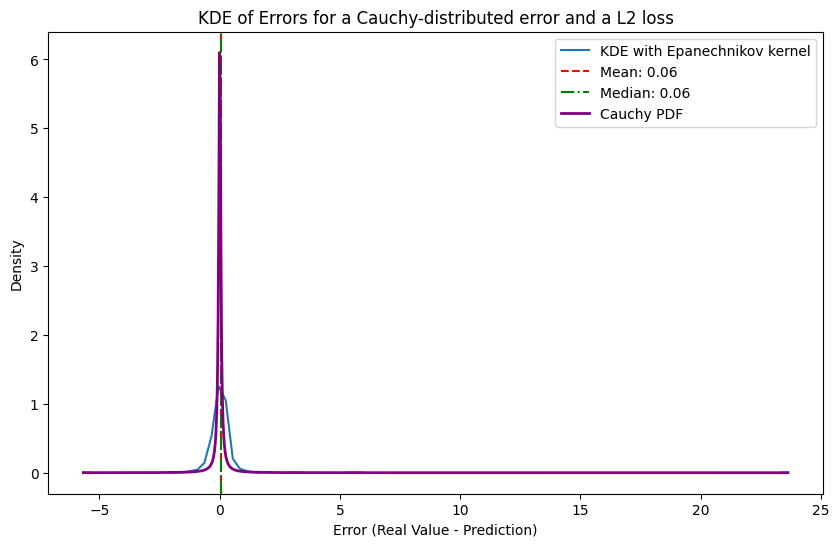

Analyzing errors for Huber loss...

Mean: -0.049711091005995474 vs. Theoretical Mean: None
Median: -0.09799819600825532 vs. Theoretical Median: None
Standard Dev.: 1.180426637848525 vs. Theoretical Std. Dev.: None
Skew: 16.994897727147343
Kurtosis: 344.3165040810921
Max: 23.88977927778667
Min: -5.759195864724239




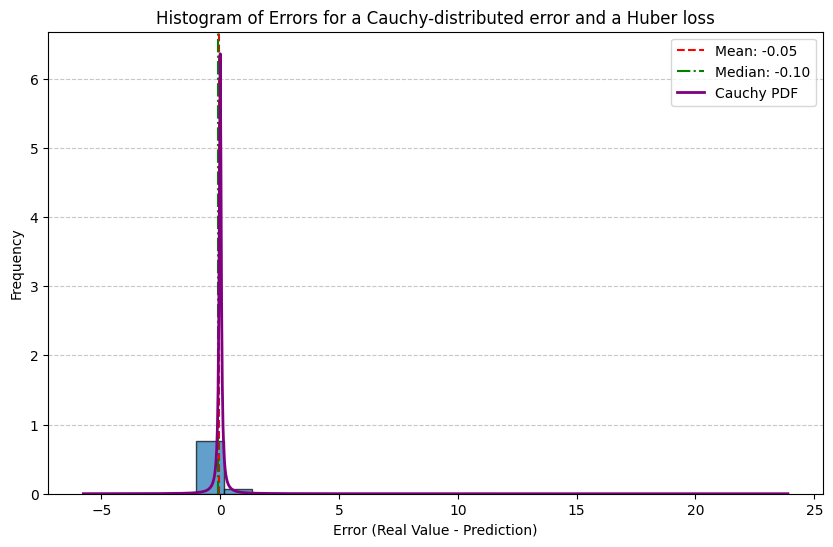

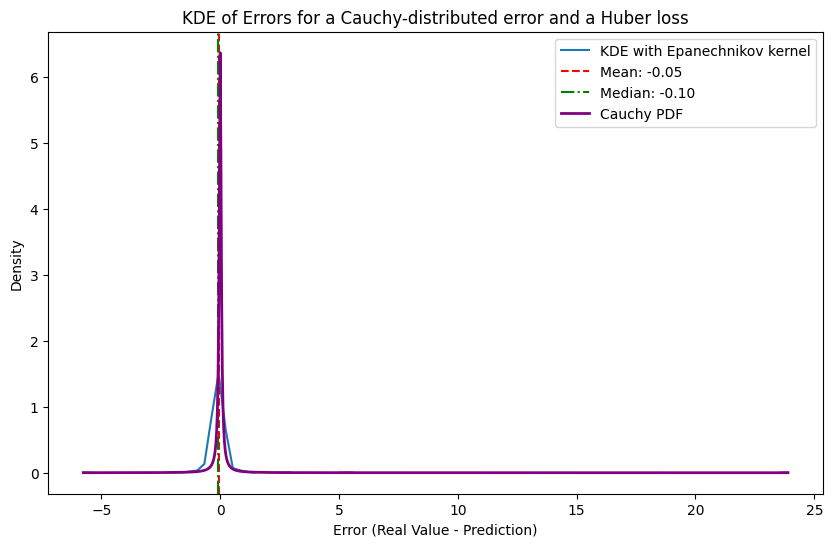

In [13]:
results = {}

for loss, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    results[loss] = stats_results(errors,theory)

    plot_hist = RecoveryPlotHist(errors=errors,dist=normal)
    plot_hist.get_plot(loss_name=loss)

    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    plot_kernel = RecoveryPlotKernel(errors=errors,dist=normal,kernel="epa",bw=bw)
    plot_kernel.get_plot(loss_name=loss)

**Gumbel Stochastic Process**

We simulate the time series with a Gumbel-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{Gumbel}(1.5,3.5)$$

In [6]:
n = 1000

series_list = []
loc = -4*np.euler_gamma
scale = 4

for i in range(0, n):
    value = gumbel_dist(1,loc,scale)
    series_list.append(value)

series = pd.DataFrame(series_list, columns=["Value"])



print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")

plt.figure(figsize=(10, 6))
plt.plot(series.index, series['Value'], label='Serie Temporal')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie Temporal con Error Gumbel')
plt.legend()
plt.show()

NameError: name 'gumbel_dist' is not defined

Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.


Training with MSE loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0256 - mae: 0.1216 - mse: 0.0256  
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166 - mae: 0.0997 - mse: 0.0166
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - mae: 0.0919 - mse: 0.0144
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - mae: 0.0933 - mse: 0.0146
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165 - mae: 0.0990 - mse: 0.0165
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - mae: 0.0945 - mse: 0.0153
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175 - mae: 0.1008 - mse: 0.0175
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0139 - mae: 0.0905 - mse: 0.0139  
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0141 - mae: 0.0938 - mse: 0.0141  
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - mae: 0.0949 - mse: 0.0147
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mae: 0

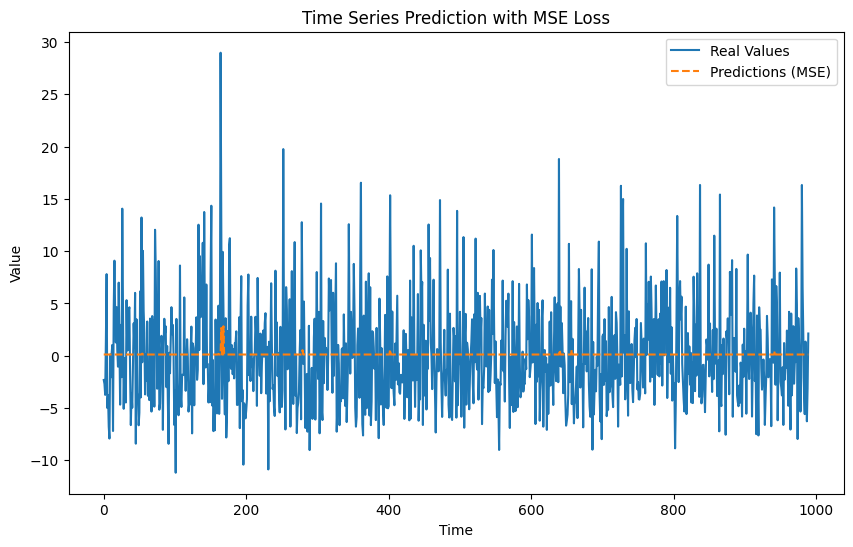


Training with MAE loss...

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0968 - mae: 0.0968 - mse: 0.0165
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0875 - mae: 0.0875 - mse: 0.0134
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0936 - mae: 0.0936 - mse: 0.0149
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0936 - mae: 0.0936 - mse: 0.0157
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0945 - mae: 0.0945 - mse: 0.0151
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0931 - mae: 0.0931 - mse: 0.0151
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0959 - mae: 0.0959 - mse: 0.0163   
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0934 - mae: 0.0934 - mse: 0.0147
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0965 - mae: 0.0965 - mse: 0.0159  
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0929 - mae: 0.0929 - mse: 0.0149
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━

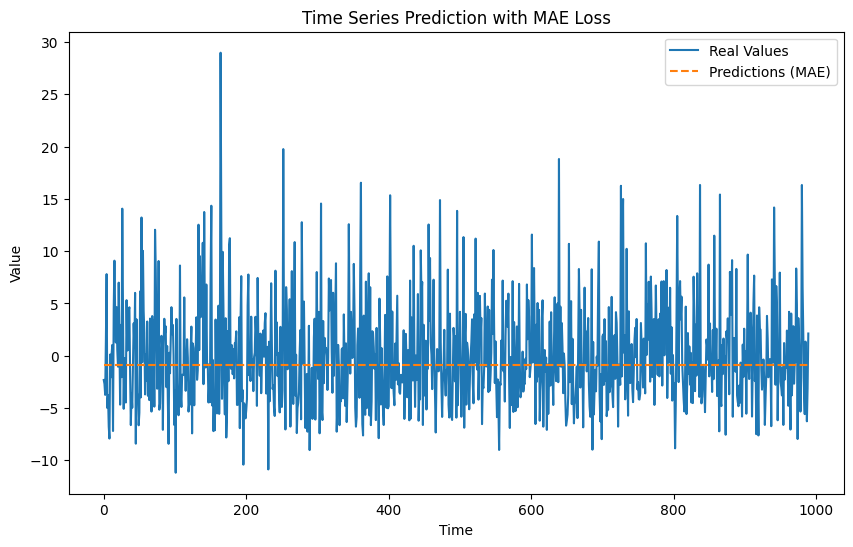


Training with Huber loss...

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074 - mae: 0.0955 - mse: 0.0147  
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mae: 0.0932 - mse: 0.0139
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0072 - mae: 0.0924 - mse: 0.0145  
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0082 - mae: 0.0962 - mse: 0.0165
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076 - mae: 0.0948 - mse: 0.0152
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 - mae: 0.0973 - mse: 0.0155
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 - mae: 0.0952 - mse: 0.0154  
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0075 - mae: 0.0966 - mse: 0.0149  
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mae: 0.1026 - mse: 0.0173
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 - mae: 0.0919 - mse: 0.0137  
Epoch 11/50
62/62 ━━━━━━━━━━━

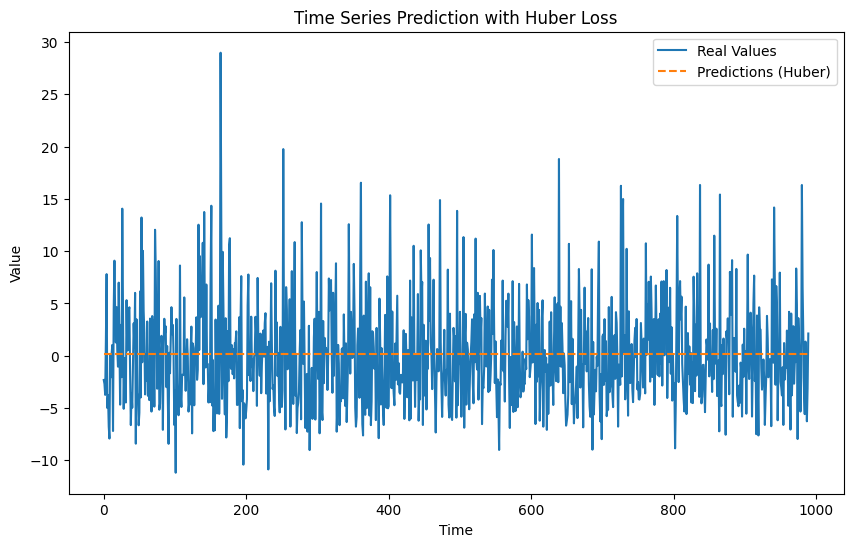

MSE Loss Evaluation: {'loss': 0.01487771887332201, 'mae': 0.09492973983287811, 'mse': 0.01487771887332201}
MAE Loss Evaluation: {'loss': 0.09369762241840363, 'mae': 0.09369762241840363, 'mse': 0.015495249070227146}
Huber Loss Evaluation: {'loss': 0.007471140008419752, 'mae': 0.09528469294309616, 'mse': 0.014942280016839504}


In [6]:
scaler = MinMaxScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 10
data = series["Value"].values
x, y = create_sequences(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "MSE": "mse",
    "MAE": "mae",
    "Huber": keras.losses.Huber(delta=1.0)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Real Values")
    plt.plot(predicted_values, label=f"Predictions ({loss_name})", linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Time Series Prediction with {loss_name} Loss")
    plt.legend()
    plt.show()

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for MSE loss...

Mean: -0.08487545697037728 vs. Theoretical Mean: 0.0
Median: -0.8590743215400568 vs. Theoretical Median: -0.8428109772794741
Standard Dev.: 4.898329178595596 vs. Theoretical Std. Dev.: 5.130199320647456
Skew: 0.9833476715513325
Kurtosis: 4.830907804203463
Max: 28.860806946985974
Min: -11.3039361630173




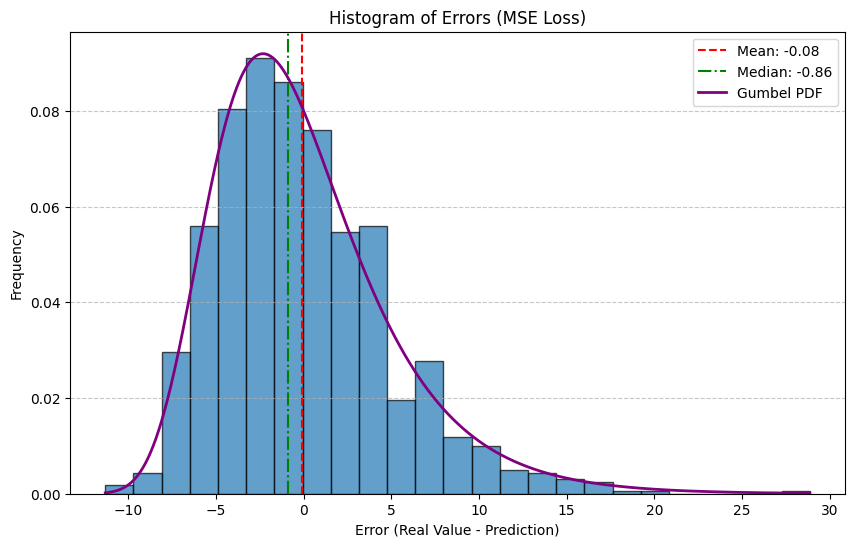

C:\Users\Iker\AppData\Local\Temp\ipykernel_20936\2402495314.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = np.array([float(kde.evaluate(val)) for val in x])


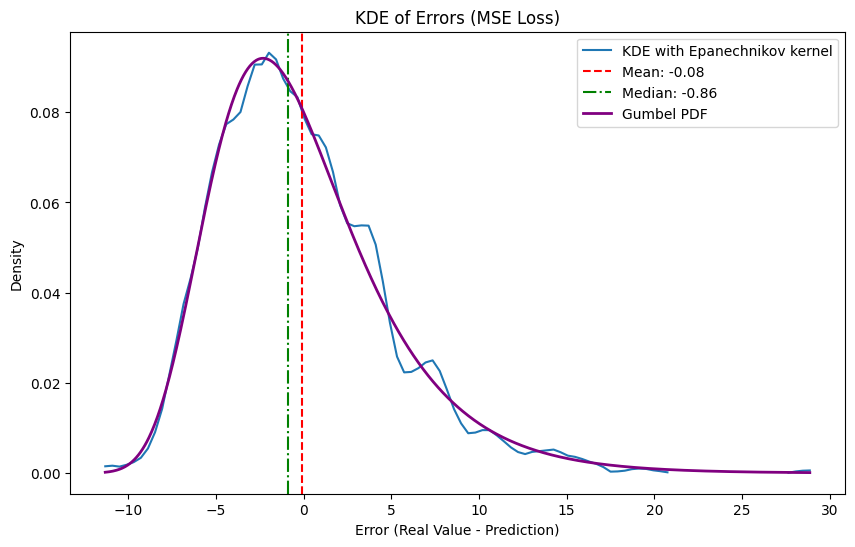

Analyzing errors for MAE loss...

Mean: 0.9546137107325433 vs. Theoretical Mean: 0.0
Median: 0.17280777081662502 vs. Theoretical Median: -0.8428109772794741
Standard Dev.: 4.907722947836332 vs. Theoretical Std. Dev.: 5.130199320647456
Skew: 0.9856697443753997
Kurtosis: 4.8256999449401246
Max: 29.892689039342656
Min: -10.272054070660618




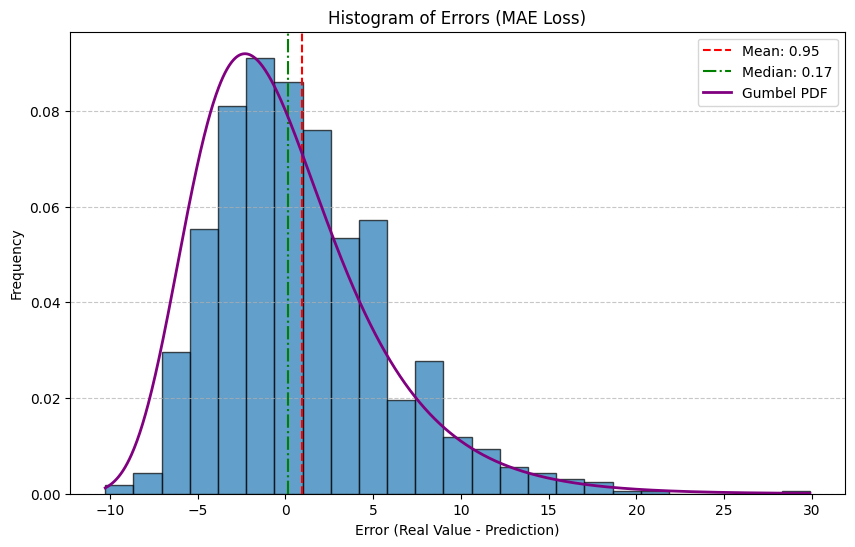

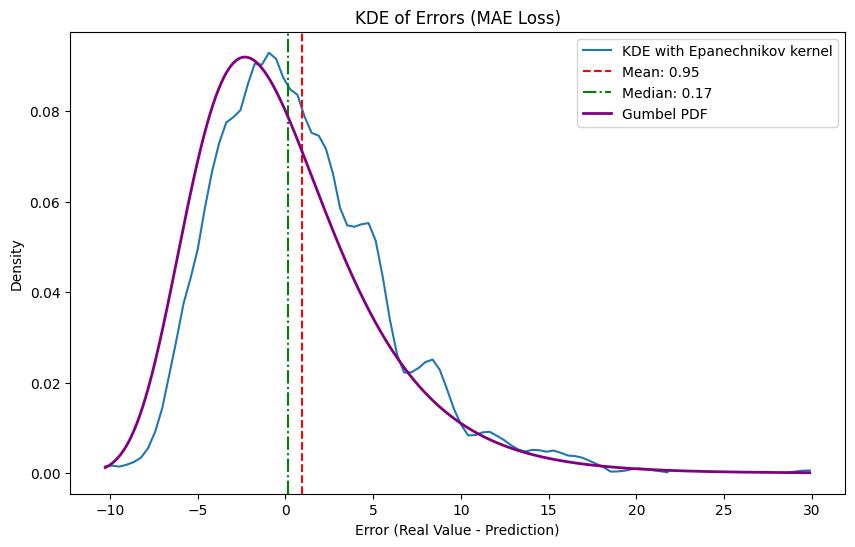

Analyzing errors for Huber loss...

Mean: -0.13870335093013073 vs. Theoretical Mean: 0.0
Median: -0.9205092908460489 vs. Theoretical Median: -0.8428109772794741
Standard Dev.: 4.907722947836333 vs. Theoretical Std. Dev.: 5.130199320647456
Skew: 0.9856697443753994
Kurtosis: 4.825699944940124
Max: 28.799371977679982
Min: -11.365371132323292




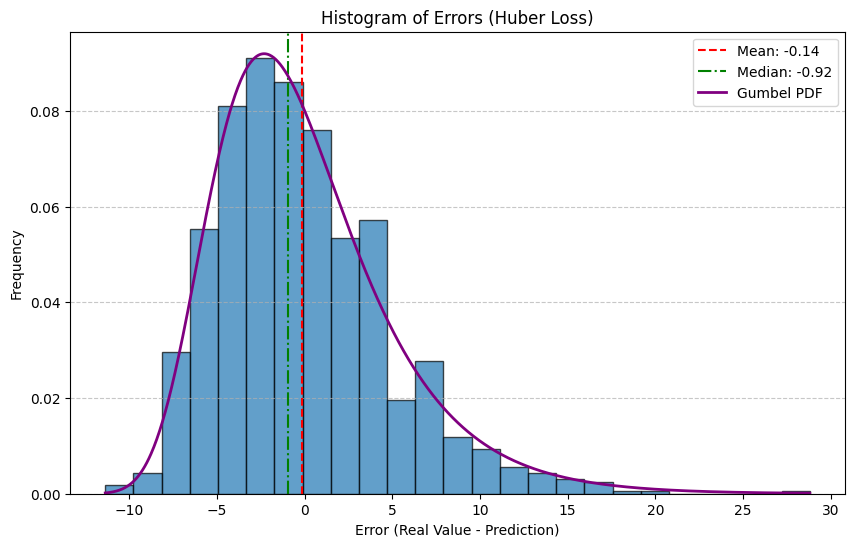

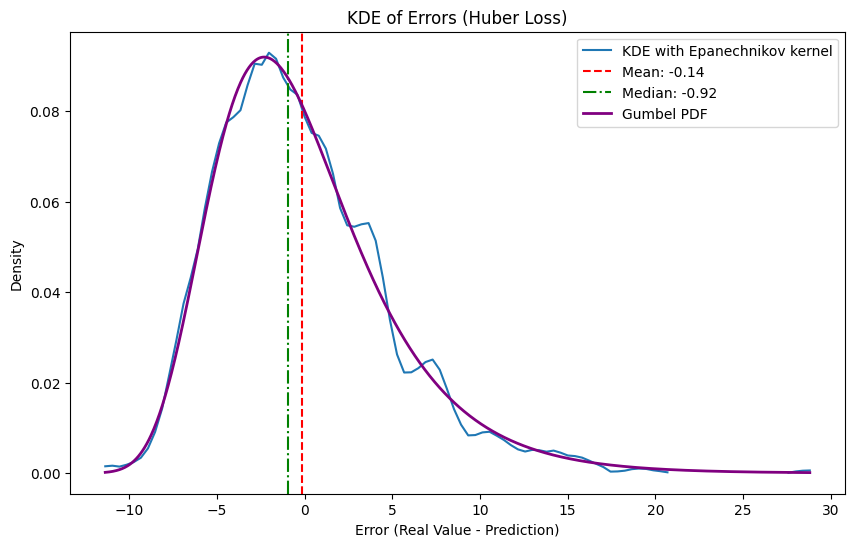

In [7]:
results = {}

for loss_name, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss_name} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    stat, p_value, skew, kurtosis = jarque_bera(errors)

    x_pdf = np.linspace(errors.min(), errors.max(), 1000)
    pdf = gumbel_pdf(x_pdf, loc=loc, scale=scale)
    
    results[loss_name] = {
        "mean": errors.mean(),
        "std": errors.std(),
        "skew": skew,
        "kurtosis": kurtosis,
        "max": errors.max(),
        "min": errors.min(),
    }
    
    print(f"Mean: {errors.mean()} vs. Theoretical Mean: {theory["mean"]}")
    print(f"Median: {np.median(errors)} vs. Theoretical Median: {theory["median"]}")
    print(f"Standard Dev.: {errors.std()} vs. Theoretical Std. Dev.: {theory["std"]}")
    print(f"Skew: {skew}")
    print(f"Kurtosis: {kurtosis}")
    print(f"Max: {errors.max()}")
    print(f"Min: {errors.min()}")
    print("\n")

    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=25, edgecolor='k', alpha=0.7, density=True)
    plt.axvline(errors.mean(), color='red', linestyle='--', label=f"Mean: {errors.mean():.2f}")
    plt.axvline(np.median(errors), color='green', linestyle='-.', label=f"Median: {np.median(errors):.2f}")
    plt.plot(x_pdf, pdf, color='purple', linestyle='-', linewidth=2, label="Gumbel PDF")
    plt.xlabel("Error (Real Value - Prediction)")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Errors ({loss_name} Loss)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
    kde = KDEUnivariate(errors)
    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    kde.fit(kernel='epa', bw=bw, fft=False)
    x = np.linspace(errors.min(), errors.max(), 100)
    y = np.array([float(kde.evaluate(val)) for val in x])
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="KDE with Epanechnikov kernel")
    plt.axvline(errors.mean(), color='red', linestyle='--', label=f"Mean: {errors.mean():.2f}")
    plt.axvline(np.median(errors), color='green', linestyle='-.', label=f"Median: {np.median(errors):.2f}")
    plt.plot(x_pdf, pdf, color='purple', linestyle='-', linewidth=2, label="Gumbel PDF")
    plt.xlabel("Error (Real Value - Prediction)")
    plt.ylabel("Density")
    plt.title(f"KDE of Errors ({loss_name} Loss)")
    plt.legend()
    plt.show()

**Log-Normal Stochastic Process**

We simulate the time series with a Lognormal-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{logN}(0,2)$$

Theoretical Mean: 7.38905609893065
Theoretical Std. Dev.: 54.095839368740585
Theoretical Median: 1.0



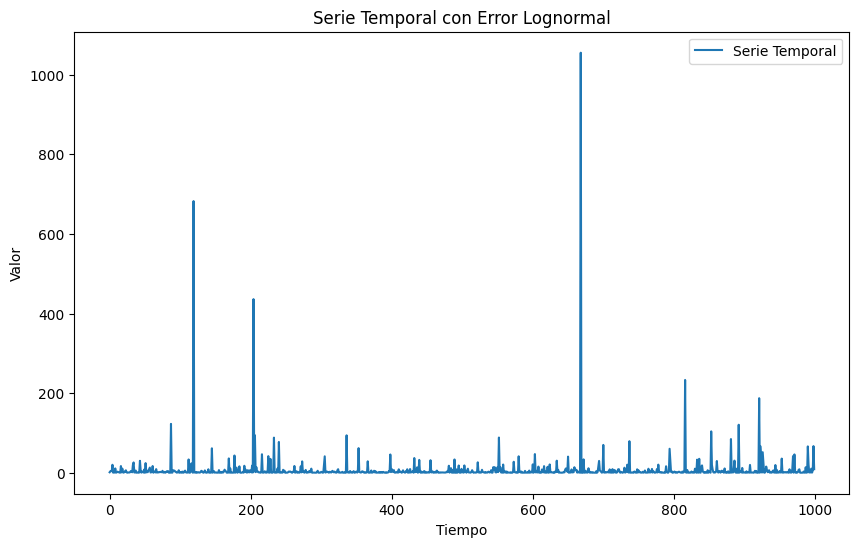

In [8]:
n = 1000

series_list = []
loc = 0
scale = 2

for i in range(0, n):
    value = np.random.lognormal(mean=loc, sigma=scale, size=1)
    series_list.append(value)

series = pd.DataFrame(series_list, columns=["Value"])

theory = {
    "mean": np.exp(loc+(scale**2)/2),
    "std": np.sqrt((np.exp(scale**2)-1)*np.exp(2*loc+scale**2)),
    "median": np.exp(loc),
}

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")

plt.figure(figsize=(10, 6))
plt.plot(series.index, series['Value'], label='Serie Temporal')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie Temporal con Error Lognormal')
plt.legend()
plt.show()

Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.


Training with MSE loss...



c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0043 - mae: 0.0212 - mse: 0.0043        
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - mae: 0.0107 - mse: 0.0010        
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0309e-04 - mae: 0.0125 - mse: 8.0309e-04  
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - mae: 0.0103 - mse: 0.0018        
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0097 - mse: 0.0016        
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7067e-04 - mae: 0.0080 - mse: 6.7067e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mae: 0.0108 - mse: 0.0012       
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0104 - mse: 0.0016        
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mae: 0.0124 - mse: 0.0013        
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - mae: 0.0157 - mse: 0.0

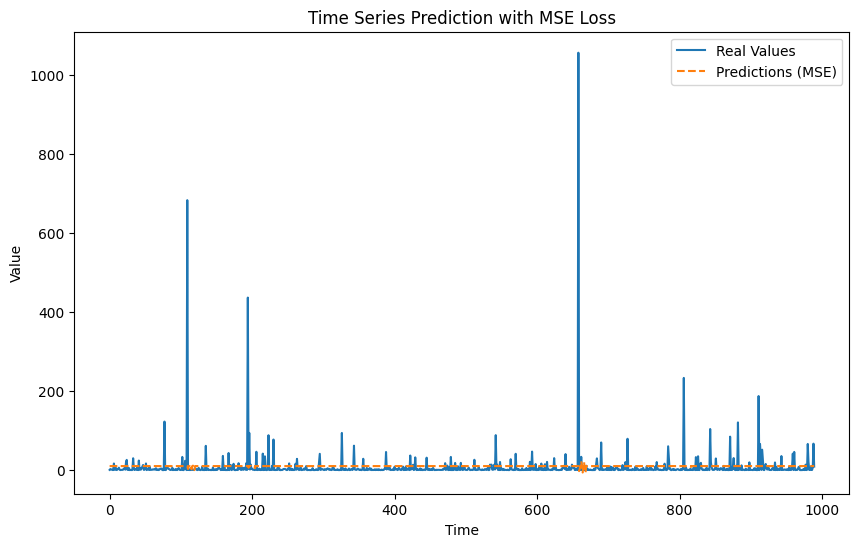


Training with MAE loss...

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080 - mae: 0.0080 - mse: 0.0020      
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0086 - mae: 0.0086 - mse: 0.0029    
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0066 - mae: 0.0066 - mse: 0.0018    
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 - mae: 0.0064 - mse: 6.6574e-04
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0067 - mse: 0.0019            
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - mae: 0.0077 - mse: 0.0019   
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - mae: 0.0079 - mse: 0.0024   
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0060 - mse: 6.6831e-04
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065 - mae: 0.0065 - mse: 0.0013    
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - mae: 0.0087 - mse: 0.00

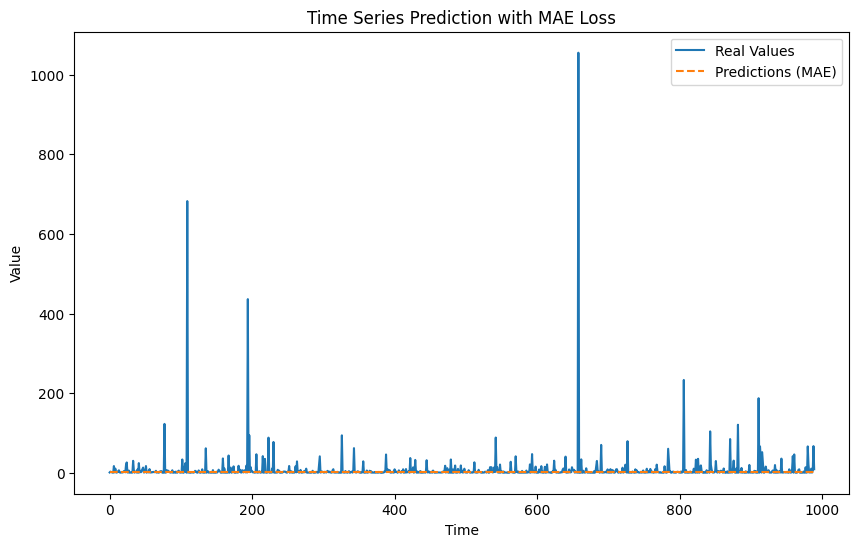


Training with Huber loss...

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016 - mae: 0.0152 - mse: 0.0033          
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mae: 0.0154 - mse: 0.0040        
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9214e-04 - mae: 0.0109 - mse: 0.0014    
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - mae: 0.0123 - mse: 0.0026        
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5116e-04 - mae: 0.0101 - mse: 0.0017   
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7619e-04 - mae: 0.0093 - mse: 0.0018   
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - mae: 0.0127 - mse: 0.0030
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - mae: 0.0152 - mse: 0.0037
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1580e-04 - mae: 0.0069 - mse: 6.3160e-04  
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1438e-04 - mae

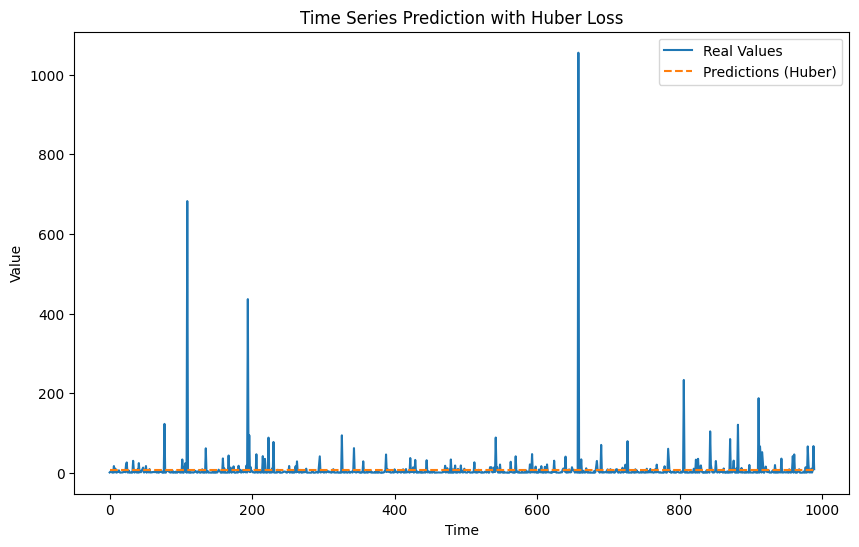

MSE Loss Evaluation: {'loss': 0.0018096363637596369, 'mae': 0.01183230895549059, 'mse': 0.0018096363637596369}
MAE Loss Evaluation: {'loss': 0.006936592049896717, 'mae': 0.006936592049896717, 'mse': 0.001842099823988974}
Huber Loss Evaluation: {'loss': 0.0009029642678797245, 'mae': 0.009314678609371185, 'mse': 0.001805928535759449}


In [9]:
scaler = MinMaxScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 10
data = series["Value"].values
x, y = create_sequences(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "MSE": "mse",
    "MAE": "mae",
    "Huber": keras.losses.Huber(delta=1.0)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Real Values")
    plt.plot(predicted_values, label=f"Predictions ({loss_name})", linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Time Series Prediction with {loss_name} Loss")
    plt.legend()
    plt.show()

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for MSE loss...

Mean: -2.462516225951327 vs. Theoretical Mean: 7.38905609893065
Median: -9.173365377046556 vs. Theoretical Median: 1.0
Standard Dev.: 44.81854183999218 vs. Theoretical Std. Dev.: 54.095839368740585
Skew: 17.518335175989098
Kurtosis: 362.73057092003586
Max: 1044.9660924186433
Min: -19.540137819332983




c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\src\TimeSeries\utils.py:41: RuntimeWarning: invalid value encountered in log
  return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2))


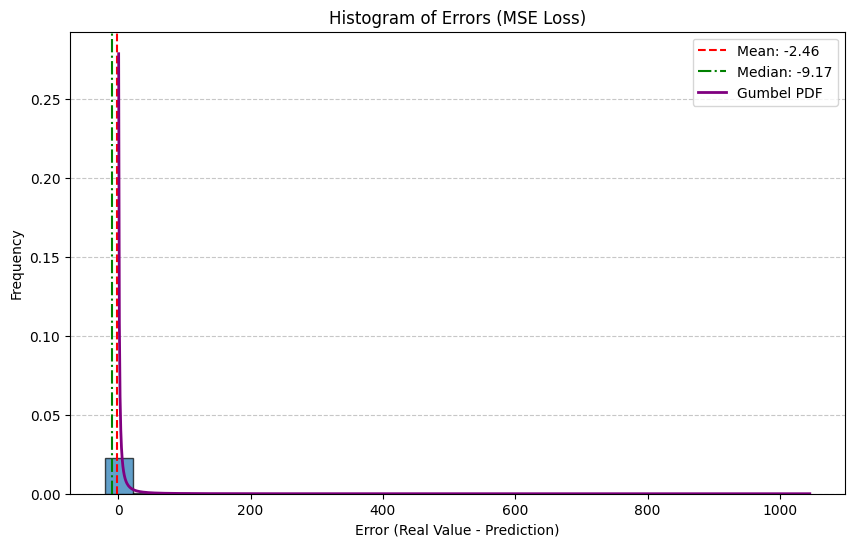

C:\Users\Iker\AppData\Local\Temp\ipykernel_20936\3074183837.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = np.array([float(kde.evaluate(val)) for val in x])


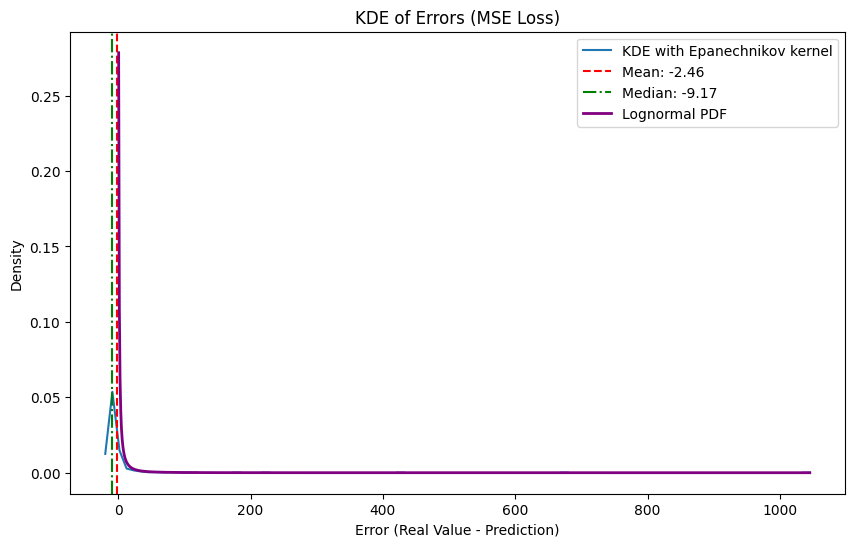

Analyzing errors for MAE loss...

Mean: 6.45972780553516 vs. Theoretical Mean: 7.38905609893065
Median: -0.22072303578798025 vs. Theoretical Median: 1.0
Standard Dev.: 44.823892824532585 vs. Theoretical Std. Dev.: 54.095839368740585
Skew: 17.517730129283752
Kurtosis: 362.6862037836014
Max: 1053.9706961621964
Min: -1.185253785792431




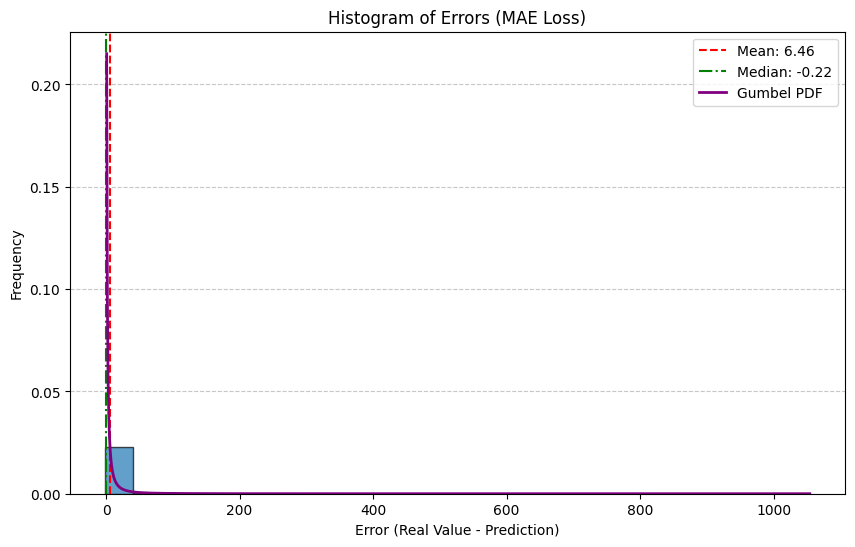

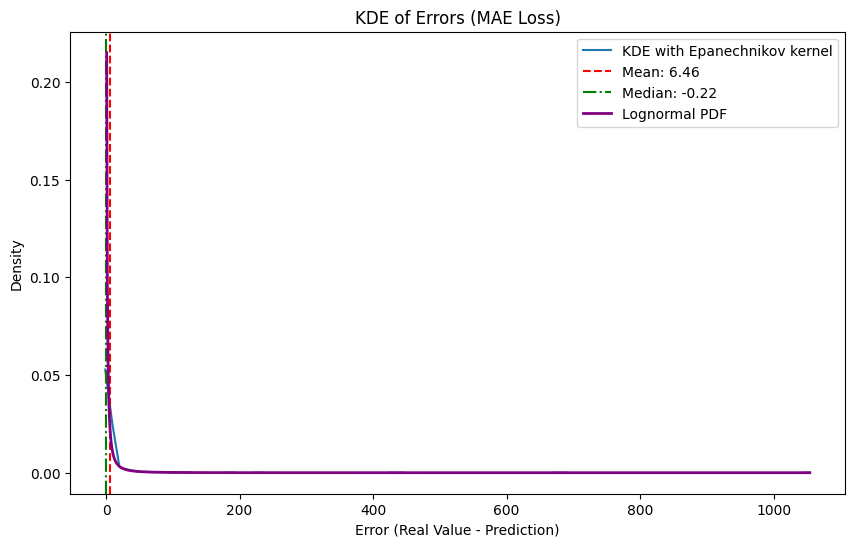

Analyzing errors for Huber loss...

Mean: 1.206858795563542 vs. Theoretical Mean: 7.38905609893065
Median: -5.473592045759599 vs. Theoretical Median: 1.0
Standard Dev.: 44.823892824532585 vs. Theoretical Std. Dev.: 54.095839368740585
Skew: 17.517730129283752
Kurtosis: 362.6862037836014
Max: 1048.7178271522248
Min: -6.438122795764049




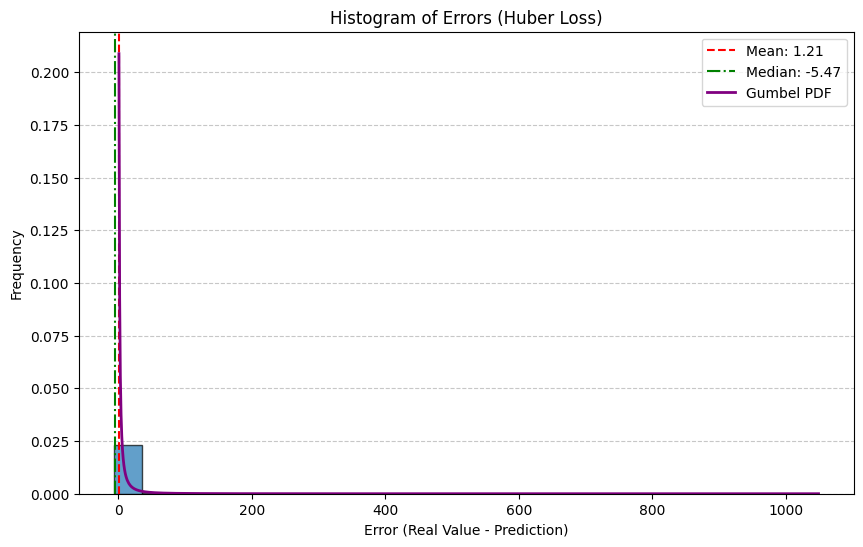

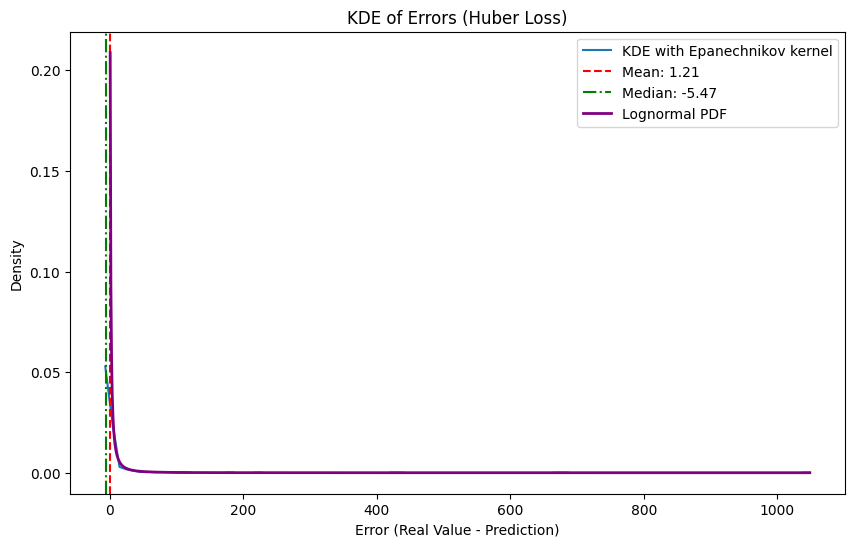

In [ ]:
results = {}

for loss_name, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss_name} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    stat, p_value, skew, kurtosis = jarque_bera(errors)

    x_pdf = np.linspace(errors.min(), errors.max(), 1000)
    pdf = lognormal_pdf(x_pdf, mu=loc, sigma=scale)
    
    results[loss_name] = {
        "mean": errors.mean(),
        "std": errors.std(),
        "skew": skew,
        "kurtosis": kurtosis,
        "max": errors.max(),
        "min": errors.min(),
    }
    
    print(f"Mean: {errors.mean()} vs. Theoretical Mean: {theory["mean"]}")
    print(f"Median: {np.median(errors)} vs. Theoretical Median: {theory["median"]}")
    print(f"Standard Dev.: {errors.std()} vs. Theoretical Std. Dev.: {theory["std"]}")
    print(f"Skew: {skew}")
    print(f"Kurtosis: {kurtosis}")
    print(f"Max: {errors.max()}")
    print(f"Min: {errors.min()}")
    print("\n")

    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=25, edgecolor='k', alpha=0.7, density=True)
    plt.axvline(errors.mean(), color='red', linestyle='--', label=f"Mean: {errors.mean():.2f}")
    plt.axvline(np.median(errors), color='green', linestyle='-.', label=f"Median: {np.median(errors):.2f}")
    plt.plot(x_pdf, pdf, color='purple', linestyle='-', linewidth=2, label="Gumbel PDF")
    plt.xlabel("Error (Real Value - Prediction)")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Errors ({loss_name} Loss)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
    kde = KDEUnivariate(errors)
    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    kde.fit(kernel='epa', bw=bw, fft=False)
    x = np.linspace(errors.min(), errors.max(), 100)
    y = np.array([float(kde.evaluate(val)) for val in x])
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="KDE with Epanechnikov kernel")
    plt.axvline(errors.mean(), color='red', linestyle='--', label=f"Mean: {errors.mean():.2f}")
    plt.axvline(np.median(errors), color='green', linestyle='-.', label=f"Median: {np.median(errors):.2f}")
    plt.plot(x_pdf, pdf, color='purple', linestyle='-', linewidth=2, label="Lognormal PDF")
    plt.xlabel("Error (Real Value - Prediction)")
    plt.ylabel("Density")
    plt.title(f"KDE of Errors ({loss_name} Loss)")
    plt.legend()
    plt.show()

**Pareto Stochastic Process**

We simulate the time series with a Pareto-distributed error term. In this case, the time series will be a function of the form:

$$f(t)=\varepsilon \quad \text{where} \quad \varepsilon \sim \mathcal{Pa}(1,3)$$

Theoretical Mean: 1.5
Theoretical Std. Dev.: 1.2599210498948732
Theoretical Median: 1.224744871391589



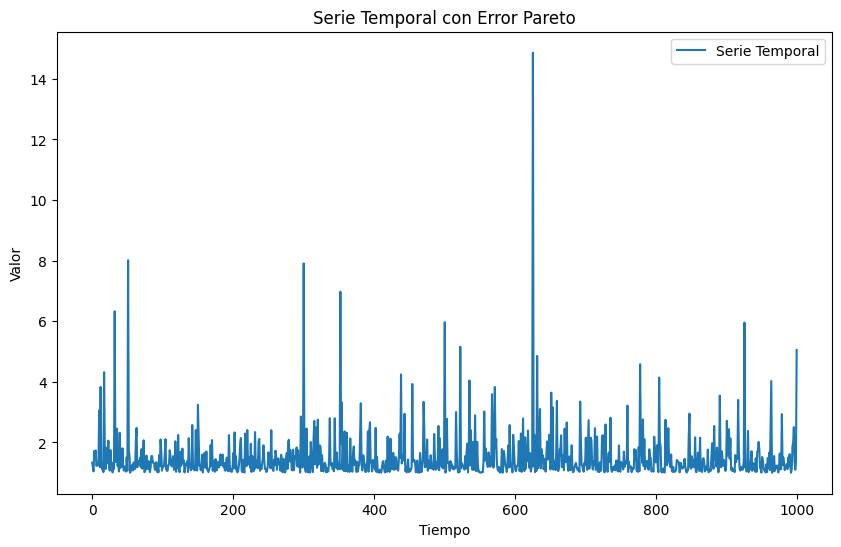

In [11]:
n = 1000

series_list = []
xm = 1
alpha = 3

for i in range(0, n):
    value = pareto_dist(1,xm,alpha)
    series_list.append(value)

series = pd.DataFrame(series_list, columns=["Value"])

theory = {
    "mean": (xm*alpha)/(alpha-1),
    "std": xm*(2**(1/alpha)),
    "median": xm*np.sqrt(alpha/((alpha-1)*(alpha-2))),
}

print(f"Theoretical Mean: {theory["mean"]}")
print(f"Theoretical Std. Dev.: {theory["std"]}")
print(f"Theoretical Median: {theory["median"]}\n")

plt.figure(figsize=(10, 6))
plt.plot(series.index, series['Value'], label='Serie Temporal')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie Temporal con Error Pareto')
plt.legend()
plt.show()

Then, we fit a dense neural network to our data. The architecture of this neural network is the follwoing:

- 1 linear input layer with 10 units (sequence length; can be changed)
- 1 ReLU hidden layer with 128 units
- 1 linear output layer with 1 unit
- Batch size of 16
- 50 epochs for training

We use an ADAM optimizer and we try 3 different loss funcions: the L1, the L2 and the Huber losses.


Training with MSE loss...

Epoch 1/50


c:\Users\Iker\Desktop\Algoritmos_Perrotes\ModellingError_TS\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0525 - mae: 0.6138 - mse: 1.0525  
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1671 - mae: 0.5543 - mse: 1.1671
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9148 - mae: 0.5522 - mse: 0.9148
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8353 - mae: 0.5277 - mse: 0.8353
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1332 - mae: 0.5555 - mse: 1.1332
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1002 - mae: 0.5384 - mse: 1.1002
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8410 - mae: 0.5177 - mse: 0.8410
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8208 - mae: 0.5265 - mse: 0.8208  
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9986 - mae: 0.5323 - mse: 0.9986
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0994 - mae: 0.5607 - mse: 1.0994
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2304 - mae: 0.5

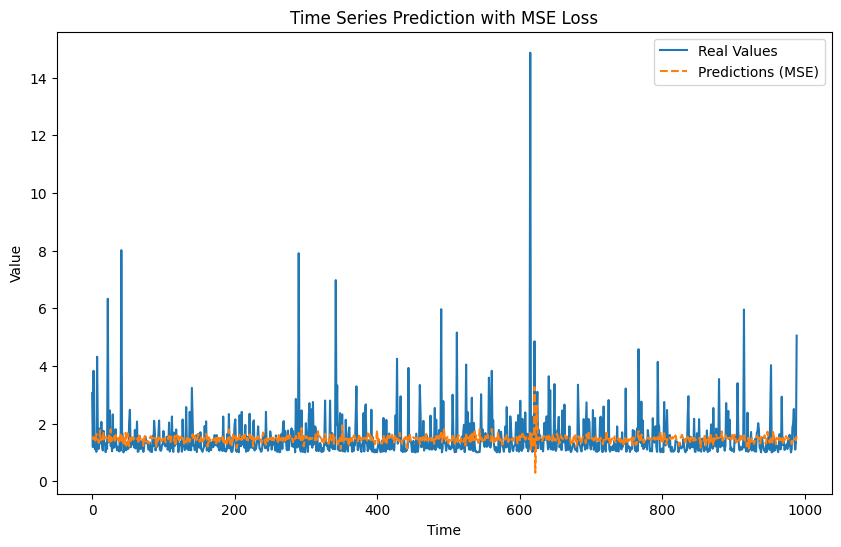


Training with MAE loss...

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4481 - mae: 0.4481 - mse: 0.6432  
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4728 - mae: 0.4728 - mse: 0.8595
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4129 - mae: 0.4129 - mse: 0.6820
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4545 - mae: 0.4545 - mse: 0.8407  
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4609 - mae: 0.4609 - mse: 1.1908  
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4732 - mae: 0.4732 - mse: 0.9367
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5445 - mae: 0.5445 - mse: 2.1069 
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4851 - mae: 0.4851 - mse: 1.1114  
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4601 - mae: 0.4601 - mse: 1.0781
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4570 - mae: 0.4570 - mse: 0.8645
Epoch 11/50
62/62 ━━━━━━━━━━━━━━

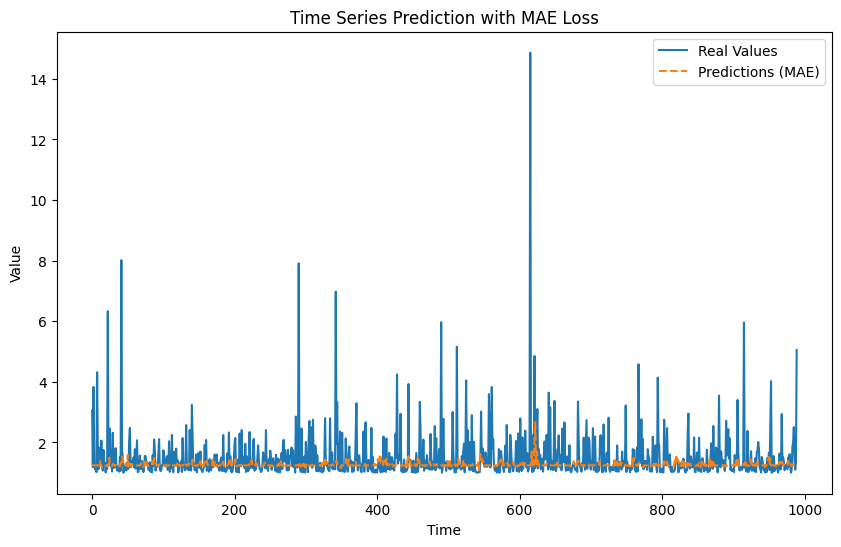


Training with Huber loss...

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2087 - mae: 0.4444 - mse: 0.7989  
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2285 - mae: 0.5000 - mse: 0.8504  
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2106 - mae: 0.4680 - mse: 1.0873  
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1961 - mae: 0.4535 - mse: 0.6667
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2530 - mae: 0.5292 - mse: 1.1873  
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2329 - mae: 0.4868 - mse: 0.9329  
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2144 - mae: 0.4729 - mse: 0.8431  
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1979 - mae: 0.4617 - mse: 0.7479  
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2234 - mae: 0.4811 - mse: 0.9294  
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2142 - mae: 0.4697 - mse: 0.8353  
Epoch 11/50
62/62 ━━━

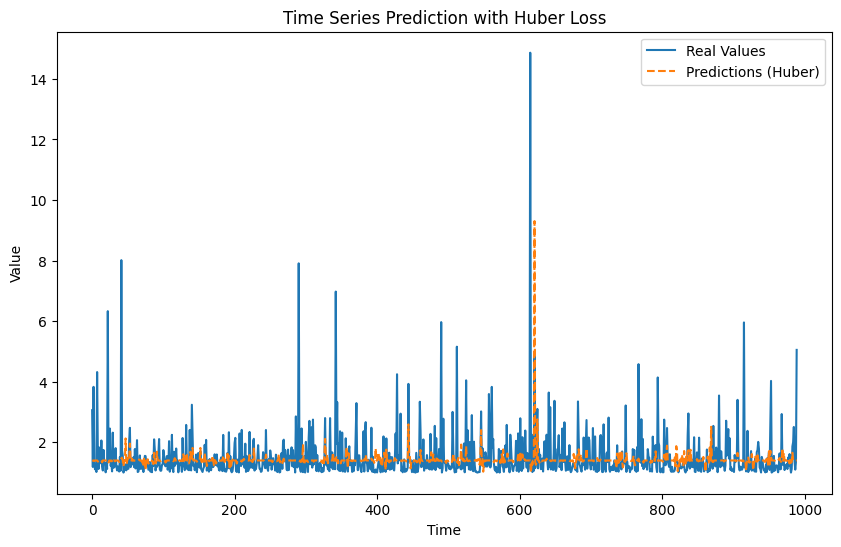

MSE Loss Evaluation: {'loss': 0.9580829739570618, 'mae': 0.5137922167778015, 'mse': 0.9580829739570618}
MAE Loss Evaluation: {'loss': 0.46379271149635315, 'mae': 0.46379271149635315, 'mse': 1.0758877992630005}
Huber Loss Evaluation: {'loss': 0.22342170774936676, 'mae': 0.49041545391082764, 'mse': 1.0013443231582642}


In [12]:
scaler = StandardScaler()
series["Value"] = scaler.fit_transform(series[["Value"]])

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 10
data = series["Value"].values
x, y = create_sequences(data, seq_length)

input_shape = (seq_length,)
x = x.reshape(x.shape[0], seq_length)

# Aprendizaje de la series

vanilla_generator = VanillaNNGenerator()
model = vanilla_generator.generate(input_shape=input_shape,
                                   units={"input": seq_length, "1": 128, "output": 1},
                                   activation={"input": None, "1": "relu", "output": None})

nn_handler = NeuralNetworkHandler(model=model)
loss_functions = {
    "MSE": "mse",
    "MAE": "mae",
    "Huber": keras.losses.Huber(delta=1.0)  # You can adjust delta as needed
}

results = {}
predictions_dict = {}

for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name} loss...\n")
    
    # Compile the model with the selected loss function
    nn_handler.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss=loss_fn,
        metrics=["mae","mse"],
        n_batches=1
    )
    
    # Train the model
    nn_handler.train(
        train_x=x,
        train_y=y,
        batch_size=16,
        epochs=50,
        shuffle=True,
        callback=None,
        y_weights=None,
        x_weights=None,
        opt_hyp=False
    )
    
    # Evaluate the model
    loss = nn_handler.evaluate(
        train_x=x,
        train_y=y,
        batch_size=16,
        x_weights=None,
        callbacks=None
    )
    print(f"Evaluation results ({loss_name}): {loss}")
    results[loss_name] = loss

    # Predict with the trained model
    predictions = nn_handler.predict(test_x=x, batch_size=16, callbacks=None)
    predicted_values = np.array(predictions["pred"])

    # Inverse transform the predictions for plotting
    predicted_values = scaler.inverse_transform(predicted_values.reshape(-1, 1))
    predictions_dict[loss_name] = predicted_values

    # Inverse transform the ground truth
    y_test = scaler.inverse_transform(y.reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Real Values")
    plt.plot(predicted_values, label=f"Predictions ({loss_name})", linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Time Series Prediction with {loss_name} Loss")
    plt.legend()
    plt.show()

# Display evaluation results
for loss_name, evaluation_result in results.items():
    print(f"{loss_name} Loss Evaluation: {evaluation_result}")

Finally, we recover the distribution of errors through an histogram and a kernel density estimation:

Analyzing errors for MSE loss...

Mean: 0.03130554179181057 vs. Theoretical Mean: 1.5
Median: -0.18438723838746185 vs. Theoretical Median: 1.224744871391589
Standard Dev.: 0.806205613518031 vs. Theoretical Std. Dev.: 1.2599210498948732
Skew: 6.881106105483104
Kurtosis: 86.24648668380418
Max: 13.187395594684778
Min: -0.7948556152291439




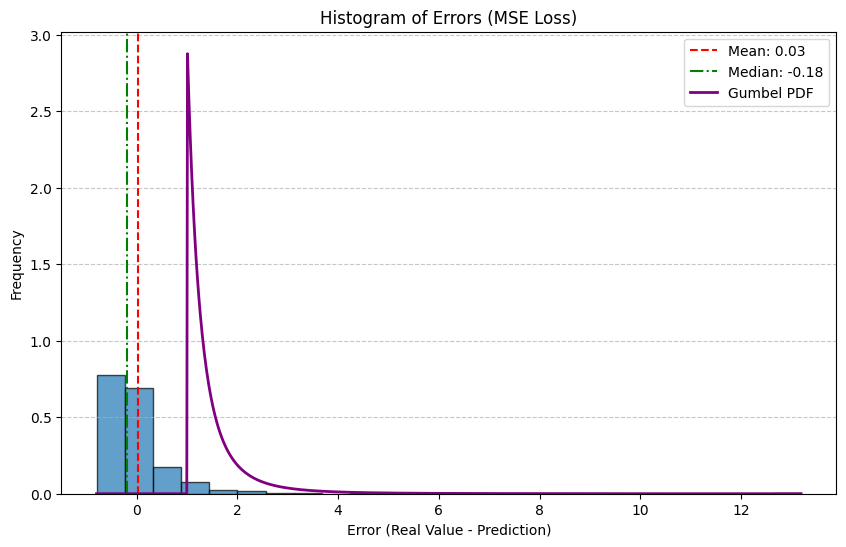

C:\Users\Iker\AppData\Local\Temp\ipykernel_20936\1645544659.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = np.array([float(kde.evaluate(val)) for val in x])


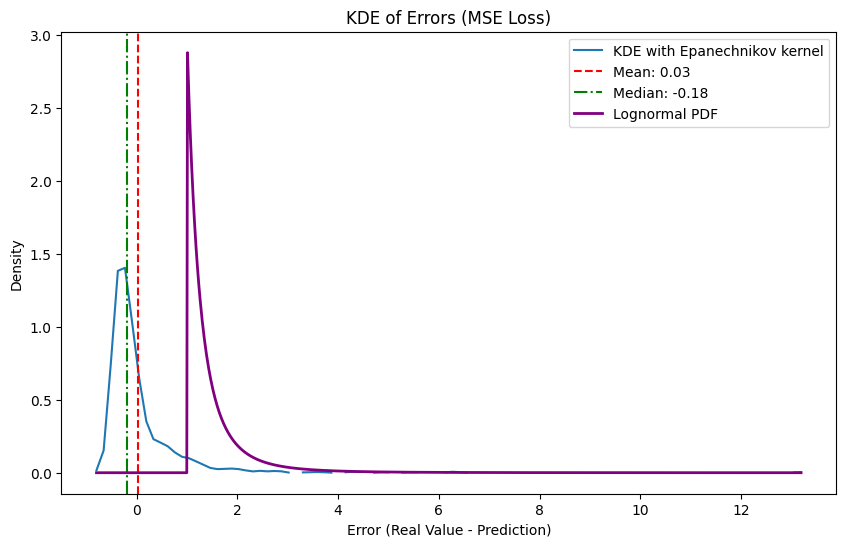

Analyzing errors for MAE loss...

Mean: 0.23237780418491427 vs. Theoretical Mean: 1.5
Median: -0.007692407378231625 vs. Theoretical Median: 1.224744871391589
Standard Dev.: 0.8227927239065946 vs. Theoretical Std. Dev.: 1.2599210498948732
Skew: 6.90191459460303
Kurtosis: 85.89642900346036
Max: 13.620754383175074
Min: -1.5172565978564612




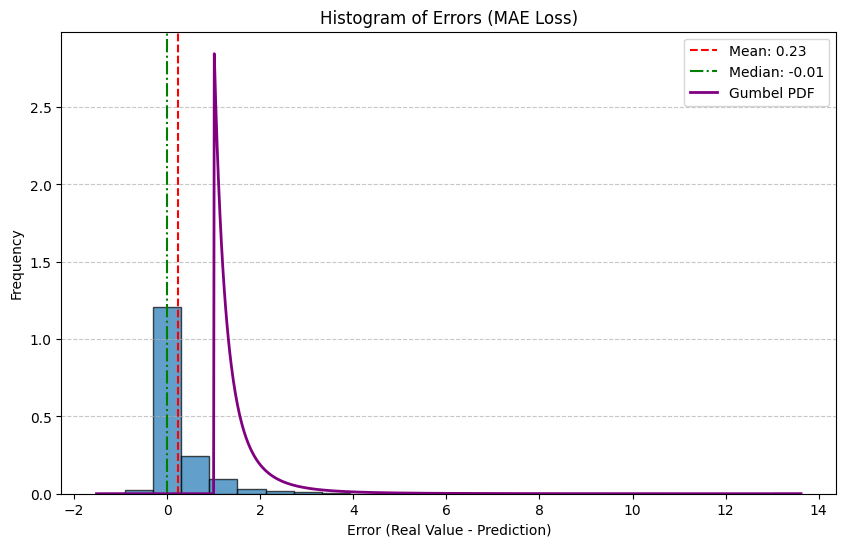

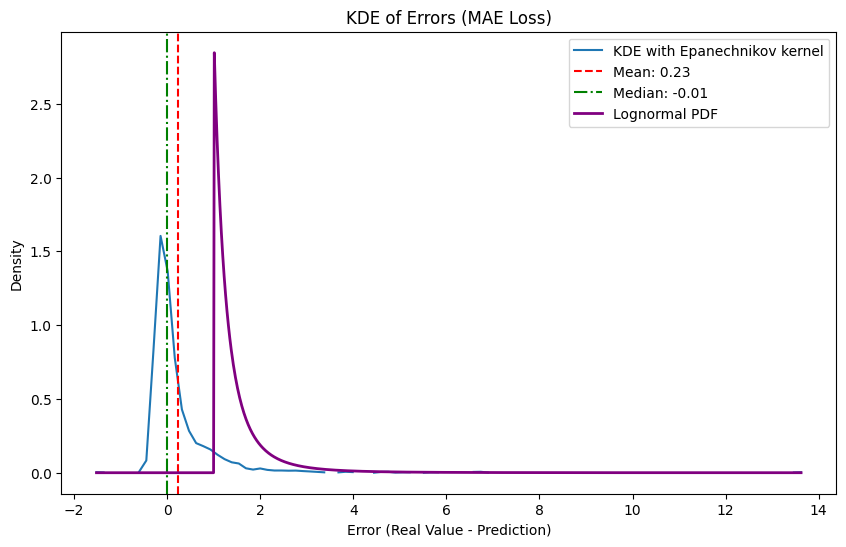

Analyzing errors for Huber loss...

Mean: 0.0755199395810625 vs. Theoretical Mean: 1.5
Median: -0.14711710886288054 vs. Theoretical Median: 1.224744871391589
Standard Dev.: 0.821363062321067 vs. Theoretical Std. Dev.: 1.2599210498948732
Skew: 6.716486390687251
Kurtosis: 87.30374913033494
Max: 13.463978908626734
Min: -4.449543329859829




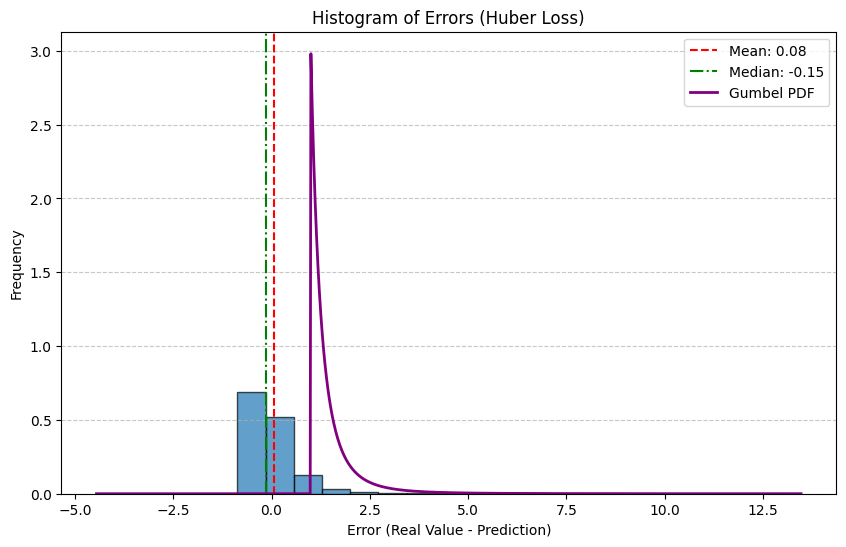

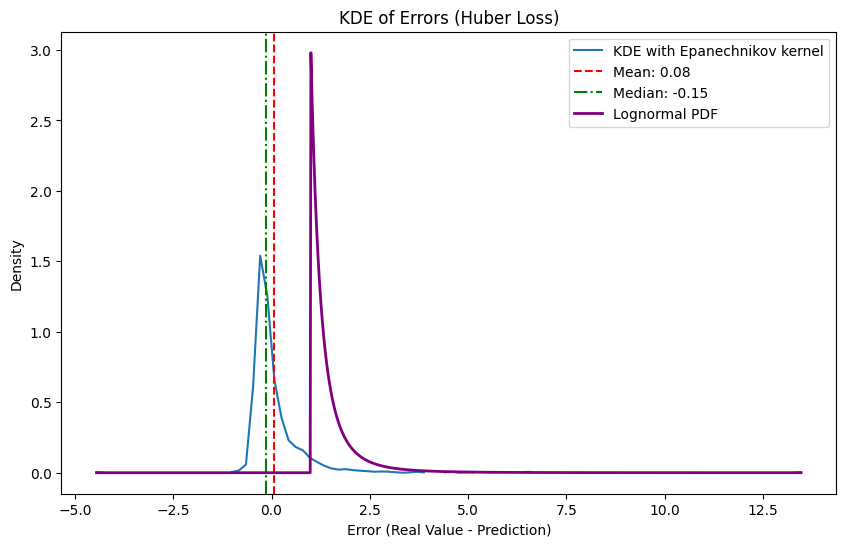

In [13]:
results = {}

for loss_name, predicted_values in predictions_dict.items():
    print(f"Analyzing errors for {loss_name} loss...\n")
    
    errors = y_test.flatten() - predicted_values.flatten()
    stat, p_value, skew, kurtosis = jarque_bera(errors)

    x_pdf = np.linspace(errors.min(), errors.max(), 1000)
    pdf = pareto_pdf(x_pdf,xm,alpha)
    
    results[loss_name] = {
        "mean": errors.mean(),
        "std": errors.std(),
        "skew": skew,
        "kurtosis": kurtosis,
        "max": errors.max(),
        "min": errors.min(),
    }
    
    print(f"Mean: {errors.mean()} vs. Theoretical Mean: {theory["mean"]}")
    print(f"Median: {np.median(errors)} vs. Theoretical Median: {theory["median"]}")
    print(f"Standard Dev.: {errors.std()} vs. Theoretical Std. Dev.: {theory["std"]}")
    print(f"Skew: {skew}")
    print(f"Kurtosis: {kurtosis}")
    print(f"Max: {errors.max()}")
    print(f"Min: {errors.min()}")
    print("\n")

    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=25, edgecolor='k', alpha=0.7, density=True)
    plt.axvline(errors.mean(), color='red', linestyle='--', label=f"Mean: {errors.mean():.2f}")
    plt.axvline(np.median(errors), color='green', linestyle='-.', label=f"Median: {np.median(errors):.2f}")
    plt.plot(x_pdf, pdf, color='purple', linestyle='-', linewidth=2, label="Gumbel PDF")
    plt.xlabel("Error (Real Value - Prediction)")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Errors ({loss_name} Loss)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
    kde = KDEUnivariate(errors)
    bw = 1.06 * np.std(errors) * len(errors)**(-1/5)
    kde.fit(kernel='epa', bw=bw, fft=False)
    x = np.linspace(errors.min(), errors.max(), 100)
    y = np.array([float(kde.evaluate(val)) for val in x])
    
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="KDE with Epanechnikov kernel")
    plt.axvline(errors.mean(), color='red', linestyle='--', label=f"Mean: {errors.mean():.2f}")
    plt.axvline(np.median(errors), color='green', linestyle='-.', label=f"Median: {np.median(errors):.2f}")
    plt.plot(x_pdf, pdf, color='purple', linestyle='-', linewidth=2, label="Lognormal PDF")
    plt.xlabel("Error (Real Value - Prediction)")
    plt.ylabel("Density")
    plt.title(f"KDE of Errors ({loss_name} Loss)")
    plt.legend()
    plt.show()

To Do:

- Gráfico ambas predicciones
- Primero sin error, después con error normal y después con error de diferentes distribuciones
- Separar gráficos de entrenamiento